# Transformer and Evolution Model for Text-to-Image Generation (MNIST Digits)

## 1. Conceptual Overview

This model demonstrates how language and vision can be fused through a unified deep-learning framework.  
The task is simple in scope but fundamental in concept:

**“Given a textual description of a digit (‘zero’ to ‘nine’), generate its corresponding handwritten image.”**

Even though the dataset (MNIST) is small and grayscale, the architecture mimics the text-to-image paradigm used in modern systems such as **DALL·E**, **Imagen**, and **Stable Diffusion**, but on a minimal, educational scale.

The system learns a **semantic alignment** between discrete text tokens and continuous image patterns by training end-to-end on paired data:

*(word label → digit image)*

---

## 2. Architectural Components

### 2.1 Text Tokenization and Embedding

Each word (“zero”, “one”, ..., “nine”) is first mapped to an integer index via a lookup dictionary (`token_map`).  
These indices form the discrete vocabulary space (10 tokens total).  
An embedding layer converts each token into a dense vector of dimension `embed_dim = 32`.

This embedding process gives semantic “meaning” to each number word in a vector space, allowing the Transformer to process it as continuous data.

Mathematically:

$$
x_i = \text{Embedding}(token_i) \in \mathbb{R}^{32}
$$

---

### 2.2 Transformer Encoder (Text Understanding)

The Transformer Encoder captures internal relationships and dependencies between input tokens — even though here we use only one token per input, it serves as a powerful text feature extractor.

It is composed of **multi-head self-attention layers** and **feedforward sub-layers**, producing a **contextual embedding** that represents the input meaning.

Formula for a single layer:

$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

where \( Q, K, V \) are projections of the input embedding.

In this simplified case, the model learns:

- “seven” → latent representation resembling the digit 7  
- “zero” → latent representation resembling the digit 0  

---

### 2.3 Latent Bridge (Evolution Step)

After the encoder, we use a fully connected bridge layer:

```python
self.bridge = nn.Linear(embed_dim, embed_dim)


This acts as the evolution link — transforming the text feature vector into a suitable latent representation that can be interpreted by the visual decoder.  
It plays the same conceptual role as the cross-modal projection in text-to-image models like CLIP or DALL·E’s prior.

## 2.4 CNN Decoder (Image Generation)

The decoder evolves the latent code into a 2D image.

A fully connected layer expands the 32-dimensional latent vector into a 3-D tensor (128×7×7).  
Two transposed convolution (deconvolution) layers gradually upsample this tensor to a 28×28 grayscale image.

Each transposed convolution layer doubles the spatial resolution while learning spatial filters that shape the image’s fine details:

ConvTranspose2d(128 → 64) → produces 14×14  
ConvTranspose2d(64 → 1) → produces 28×28  

A final **Sigmoid** activation ensures pixel values stay within [0, 1].

---

## 3. Training Objective

The model is trained using **Mean Squared Error (MSE)** between generated and real MNIST images:

$$
\mathcal{L} = \frac{1}{N} \sum_i \| \hat{I}_i - I_i \|_2^2
$$

This loss encourages pixel-level similarity between the reconstructed and target images.  
While simple, it’s sufficient for low-dimensional grayscale images.

- **Optimizer:** Adam (adaptive gradient descent)  
- **Learning rate:** 0.001  

---

## 4. Training Process

Each batch consists of:

- Text tokens → fed to the Transformer encoder  
- Corresponding MNIST images → target outputs  

For **5 epochs**:

1. The Transformer learns embeddings for number words.  
2. The CNN decoder learns to reconstruct MNIST digits that match each word’s meaning.  
3. The latent bridge ensures gradients flow smoothly from image to text domain.

Training time ≈ **5–10 minutes** on GPU.

---

## 5. Generation (Inference)

At inference time, we can enter a word like `"seven"`, and the model:

1. Encodes the text into a latent vector \( z \)  
2. Decodes \( z \) into an image via the CNN decoder  
3. Produces an output resembling the handwritten “7”

This works for all 10 digits:

python
samples = ["zero", "one", ..., "nine"]

The model can synthesize images for each class purely from textual input — no numeric labels or manual hints.

---

## 6. Evolutionary Path (Why “Evolution” Model?)

This model demonstrates the evolution of meaning:

**Text → latent space → visual form**

It acts as a miniature blueprint for multimodal AI:

- The Transformer evolves linguistic symbols into latent semantics.  
- The Decoder evolves semantics into visual geometry.  

Together, they simulate how models like **Stable Diffusion** operate at scale.  
Hence, it’s called an **Evolution Model** — because it evolves a linguistic signal into an emergent visual structure.

---

## 7. Future Directions

| Enhancement | Description | Goal |
|:--|:--|:--|
| Diffusion Head | Replace CNN decoder with diffusion sampling network | Realistic image synthesis |
| Cross-Attention Bridge | Add attention between text tokens and visual latents | Learn word-level conditioning |
| CLIP Alignment | Use pretrained text/image embeddings | Semantic consistency |
| Variational Latent Space | Add stochastic sampling (VAE-style) | Improve diversity of outputs |
| Higher-Res Dataset | Use EMNIST or SVHN | Extend beyond digits |

---

## 8. Summary

| Stage | Module | Function | Output |
|:--|:--|:--|:--|
| Text Input | Tokenizer | Convert “seven” → [6] | Integer token |
| Transformer Encoder | Self-Attention Layers | Extract text semantics | Embedding vector |
| Bridge | Linear Layer | Align modalities | Latent representation |
| CNN Decoder | Deconv layers | Generate image | 28×28 digit |
| Loss | MSE | Compare with real MNIST | Gradient feedback |

---

### In Essence

This project is a didactic microcosm of text-to-image AI —  
a Transformer that learns to imagine numbers.


In [8]:
# ===============================================================
# Text-to-Image Transformer Evolution Model (PyTorch)
# Author: Mohammed Fahd Abrah | Programming Ocean Academy
# ===============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [9]:
# --------------------------
# 1. Text Encoding Utilities
# --------------------------
token_map = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
}
vocab = list(token_map.keys())
vocab_size = len(vocab)
embed_dim = 32

def text_to_tensor(word):
    idx = vocab.index(word)
    return torch.tensor([idx])

In [10]:
# --------------------------
# 2. Dataset Wrapper
# --------------------------
class TextToMNIST(Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST(root="./data", train=train, download=True,
                                   transform=transforms.ToTensor())
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        text = vocab[label]
        return text_to_tensor(text), img, label

In [11]:
# --------------------------
# 3. Transformer Encoder
# --------------------------
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, nhead=2, hidden_dim=64, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=hidden_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq, embed_dim)
        x = x.transpose(0, 1)  # Transformer expects (seq, batch, embed_dim)
        enc_out = self.encoder(x)
        return enc_out.mean(dim=0)  # (batch, embed_dim)

In [12]:
# --------------------------
# 4. CNN Decoder
# --------------------------
class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),    # 28x28
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 128, 7, 7)
        return self.deconv(z)

In [13]:
# --------------------------
# 5. Combined Model
# --------------------------
class TextToImageTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, embed_dim)
        self.bridge = nn.Linear(embed_dim, embed_dim)
        self.decoder = CNNDecoder(embed_dim)

    def forward(self, text_tokens):
        z = self.encoder(text_tokens)
        z = F.relu(self.bridge(z))
        img = self.decoder(z)
        return img

In [14]:
# --------------------------
# 6. Training
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextToImageTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_loader = DataLoader(TextToMNIST(train=True), batch_size=64, shuffle=True)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for txt, img, _ in train_loader:
        txt, img = txt.to(device), img.to(device)
        optimizer.zero_grad()
        out = model(txt)
        loss = criterion(out, img)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.0556
Epoch 2/5, Loss: 0.0536
Epoch 3/5, Loss: 0.0535
Epoch 4/5, Loss: 0.0535
Epoch 5/5, Loss: 0.0535


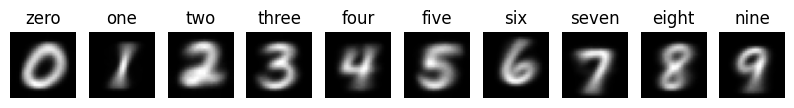

In [15]:
# --------------------------
# 7. Generate Sample Images
# --------------------------
model.eval()
samples = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
plt.figure(figsize=(10, 2))
for i, word in enumerate(samples):
    token = text_to_tensor(word).unsqueeze(0).to(device)
    with torch.no_grad():
        gen_img = model(token)[0].cpu().squeeze(0).squeeze().numpy()
    plt.subplot(1, 10, i+1)
    plt.imshow(gen_img, cmap="gray")
    plt.axis("off")
    plt.title(word)
plt.show()


Enter a number word (zero-nine): seven


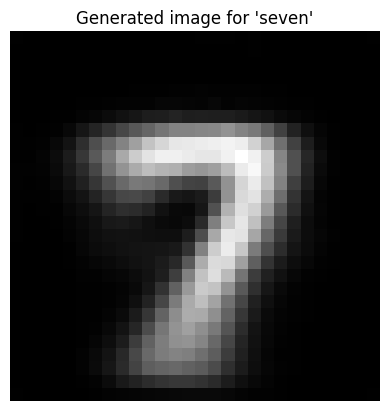

In [24]:
# ===============================================================
# 4️ Interactive Image Generator Function
# ===============================================================

def generate_digit_from_text():
    """
    Ask user once for a number word ('zero'...'nine') and generate its image.
    """
    model.eval()
    word = input("\nEnter a number word (zero-nine): ").strip().lower()
    try:
        token = text_to_tensor(word).unsqueeze(0).to(device)
        with torch.no_grad():
            gen_img = model(token)[0].cpu().squeeze(0).squeeze().numpy()
        plt.imshow(gen_img, cmap="gray")
        plt.title(f"Generated image for '{word}'")
        plt.axis("off")
        plt.show()
    except ValueError as e:
        print(e)
# ===============================================================
# 5️ Run Interactive Demo
# ===============================================================

if __name__ == "__main__":
    generate_digit_from_text()

The lab includes three primary models working together to perform text-to-image generation:

1. **Transformer Encoder**  
   - Processes the input text (e.g., “seven”) and converts it into a numerical embedding.  
   - Uses multi-head self-attention to capture contextual relationships between tokens.  
   - Outputs a semantic vector representing the meaning of the word.

2. **Latent Bridge (Linear Layer)**  
   - A fully connected transformation between the text and image domains.  
   - Aligns the Transformer’s text embedding with the visual latent space required by the decoder.  
   - Acts as the cross-modal connector — linking language understanding to visual synthesis.

3. **CNN Decoder**  
   - A convolutional neural network that converts the latent vector into a 2D image.  
   - Expands the latent representation using transposed convolutions to form the 28×28 MNIST digit.  
   - Final layer uses a Sigmoid activation to normalize pixel values between 0 and 1.

Together, these models form the **Text-to-Image Evolution Architecture**,  
which learns to translate symbolic language (words) into visual representations (digits).
